# Gradient Boosting in scikit-learn

## Data



In [1]:
from data_prep_hitters import *

## Model

In [3]:
from sklearn.ensemble import GradientBoostingRegressor

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [4]:
reg = GradientBoostingRegressor(**params)

reg.fit(X_train, y_train)

In [5]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, reg.predict(X_test))

90927.30599524264

### Plot training deviance

Source: [scikit learn](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#plot-training-deviance), provided by Peter Prettenhofer, Maria Telenczuk and Katrina Ni:

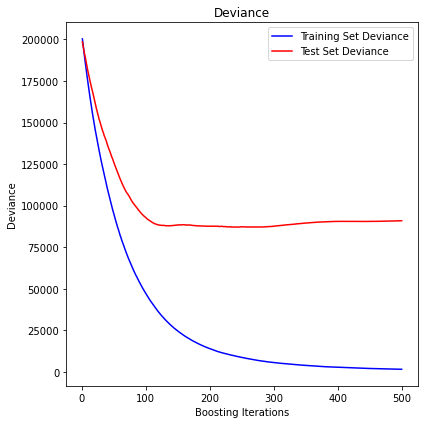

In [6]:
import matplotlib.pyplot as plt
import numpy as np

test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

### Feature importance

Next, we take a look at the tree based feature importance and the permutation importance.

#### Mean decrease in impurity (MDI)

Mean decrease in impurity (MDI) is a measure of feature importance for decision tree  models.



This problem stems from two limitations of impurity-based feature importances:

impurity-based importances are biased towards high cardinality features;

impurity-based importances are computed on training set statistics and therefore do not reflect the ability of feature to be useful to make predictions that generalize to the test set (when the model has enough capacity).



#### Permutation feature importance

Permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is tabular (see [scikit learn](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance) for more details):

- The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. 
- This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. - This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.
- The permutation importance is calculated on the training set to show how much the model relies on each feature during training.

Note however that when two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature. This will result in a lower importance value for both features, where they might actually be important. One way to handle this is to cluster features that are correlated and only keep one feature from each cluster. This strategy is explored in this example: [Permutation Importance with Multicollinear or Correlated Features](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#handling-multicollinear-features).

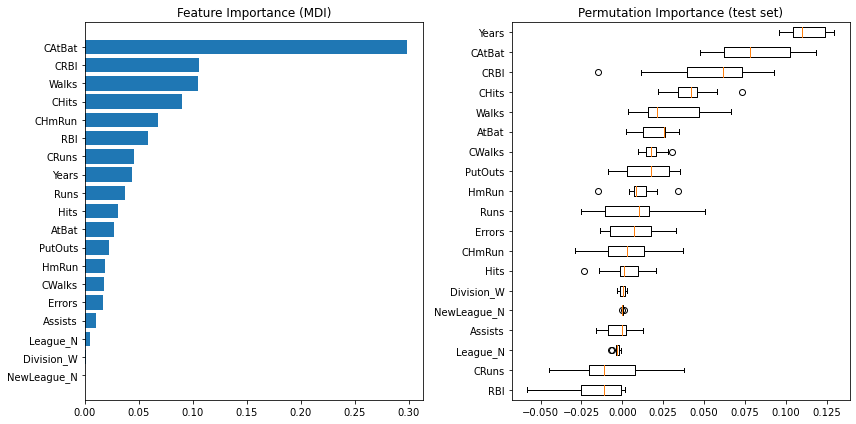

In [7]:
from sklearn.inspection import permutation_importance

feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()